# 📈 Stock Data Analysis 📉

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


Loading the dataset

The dataset contains 1.4 million news records with complete values across all six columns. 

In [2]:
df = pd.read_csv('/Users/elbethelzewdie/Documents/stock-market-challenge-week1/stock-market-challenge-week1/data/raw_analyst_ratings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


In [3]:
# Preview the first 5 rows of the dataset
df.head(5)

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [4]:
# Preview the last 5 rows of the dataset
df.tail(5)

,Unnamed: 0,headline,url,publisher,date,stock
1407323,1413844,Top Narrow Based Indexes For August 29,https://www.benzinga.com/news/11/08/1888782/to...,Monica Gerson,2011-08-29 00:00:00,ZX
1407324,1413845,Recap: Wednesday's Top Percentage Gainers and ...,https://www.benzinga.com/news/earnings/11/06/1...,Benjamin Lee,2011-06-22 00:00:00,ZX
1407325,1413846,UPDATE: Oppenheimer Color on China Zenix Auto ...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffL,2011-06-21 00:00:00,ZX
1407326,1413847,Oppenheimer Initiates China Zenix At Outperfor...,https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-06-21 00:00:00,ZX
1407327,1413848,China Zenix Auto International Opens For Tradi...,https://www.benzinga.com/news/ipos/11/05/10789...,Allie Wickman,2011-05-12 00:00:00,ZX


Checking for missing values

The dataset doesn't contain any missing values

In [5]:
# Check for missing values
df.isna().sum()

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

Dropping unimportant columns

In [6]:
# Drop unnecessary columns  
df = df.drop(columns=['url', 'Unnamed: 0'])

Counting the number of word in the headline column to do statistics 

In [7]:
# Create a new column for headline length in words
df['headline_len_words'] = df['headline'].str.split().str.len()

In [8]:
# Display the new column
df['headline_len_words']

0           7
1           7
2           5
3           7
4          14
           ..
1407323     7
1407324     7
1407325     8
1407326     8
1407327    14
Name: headline_len_words, Length: 1407328, dtype: int64

In [9]:
# Set float display format to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

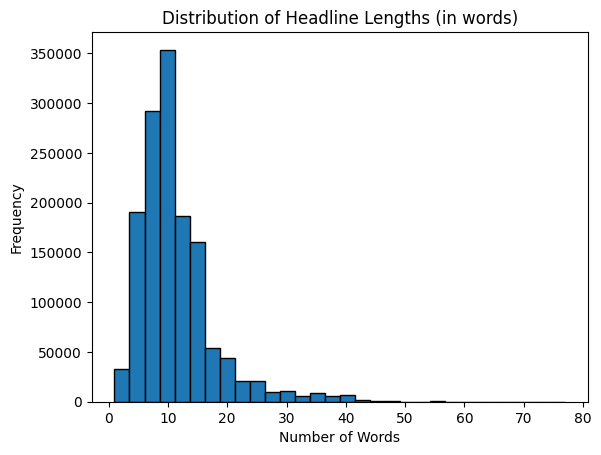

In [ ]:
# Statistical summary and histogram of headline lengths
plt.hist(df['headline_len_words'], bins=30, edgecolor='black')
plt.title('Distribution of Headline Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


In [11]:
# Statistical summary of headline lengths
df['headline_len_words'].describe()

count   1407328.00
mean         11.42
std           6.35
min           1.00
25%           7.00
50%          10.00
75%          13.00
max          77.00
Name: headline_len_words, dtype: float64

In [12]:
# Display the 5 longest headlines
df.nsmallest(5, 'headline_len_words')[['headline', 'headline_len_words']]

,headline,headline_len_words
17629,Accenture,1
26219,EX-DIVIDEND,1
45732,Adecoagro,1
81399,EX-DIVIDEND,1
127835,Amgen,1


In [13]:
# Display the 5 shortest headlines
df.nlargest(5, 'headline_len_words')[['headline', 'headline_len_words']]

,headline,headline_len_words
701748,JinkoSolar Tiger Pro Series Receives World's F...,77
39028,Shares of several financial services companies...,70
67373,Shares of several oil and gas companies are tr...,70
140048,Shares of several financial services companies...,70
140381,Shares of several financial services companies...,70


Outlier removal using inter quartile range

In [14]:
# Identify outliers using the IQR method
Q1 = df['headline_len_words'].quantile(0.25)
Q3 = df['headline_len_words'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['headline_len_words'] < lower_bound) |
              (df['headline_len_words'] > upper_bound)]

outliers[['headline', 'headline_len_words']]

,headline,headline_len_words
20,Shares of several healthcare companies are tra...,29
21,Shares of several healthcare companies are tra...,31
26,Shares of several companies in the auto dealer...,39
27,Shares of several healthcare companies are tra...,34
30,Int'l. Air Transport Authority Chief Economist...,27
...,...,...
1406776,UPDATE: Zumiez Raises Q4 EPS Guidance from $0....,24
1406787,Zumiez Inc. Reports Q3 EPS of GAAP $0.54 Which...,23
1406828,UPDATE: Zumiez Inc. Raises Q2 EPS Guidance fro...,25
1407266,Chinese Nano-Cap Momentum Stocks Sharply Highe...,38


The box plot below indicates the presence of numerous outliers in the data.

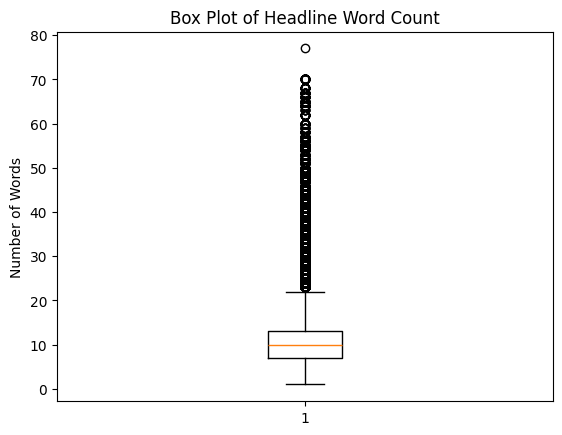

In [15]:
# Box plot to visualize outliers
plt.boxplot(df['headline_len_words'].dropna())
plt.title("Box Plot of Headline Word Count")
plt.ylabel("Number of Words")
plt.show()

In [16]:
# Remove outliers from the dataset
df_no_outliers = df[(df['headline_len_words'] >= lower_bound) &
                    (df['headline_len_words'] <= upper_bound)]

The box plot below illustrates the distribution of the data following outlier removal.

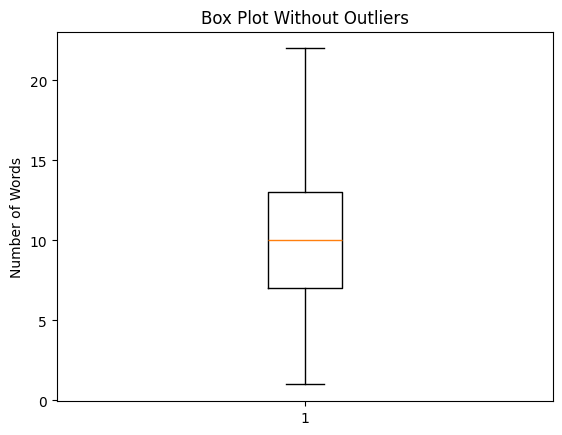

In [17]:
# Box plot without outliers
plt.boxplot(df_no_outliers['headline_len_words'])
plt.title("Box Plot Without Outliers")
plt.ylabel("Number of Words")
plt.show()

In [18]:
# Number of records after removing outliers
len(df_no_outliers)

1325325

A total of 1,034 distinct publishers are represented in the dataset.

In [19]:
# Count of headlines by publisher after removing outliers
publisher_counts = df_no_outliers['publisher'].value_counts()
print(publisher_counts)

publisher
Paul Quintaro                      212669
Lisa Levin                         186774
Benzinga Newsdesk                  110826
Charles Gross                       90273
Monica Gerson                       82121
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64


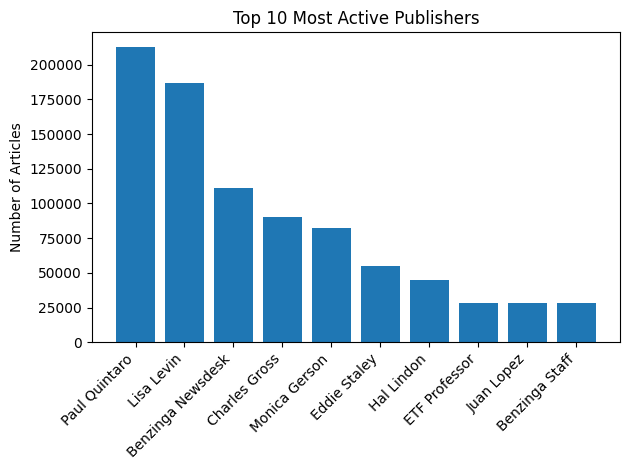

In [20]:
# Bar chart of top 10 most active publishers
top10 = df_no_outliers['publisher'].value_counts().head(10)

plt.bar(top10.index, top10.values)
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Most Active Publishers")
plt.ylabel("Number of Articles")
plt.tight_layout()
plt.show()

Time Series Analysis

In [21]:
# Convert 'date' column to datetime with timezone handling
df_clean = df_no_outliers.copy()

# Step 1: Force all values to datetime (assumes strings like '2020-06-05 10:30:54-04:00')
df_clean['date'] = pd.to_datetime(df_clean['date'], errors='coerce', utc=True)

# Step 2: Convert to desired timezone
df_clean['date'] = df_clean['date'].dt.tz_convert('America/New_York')

# Step 3: Check
print(df_clean['date'].dtype)

datetime64[ns, America/New_York]


there are high publication rate in thursday and wednesday.


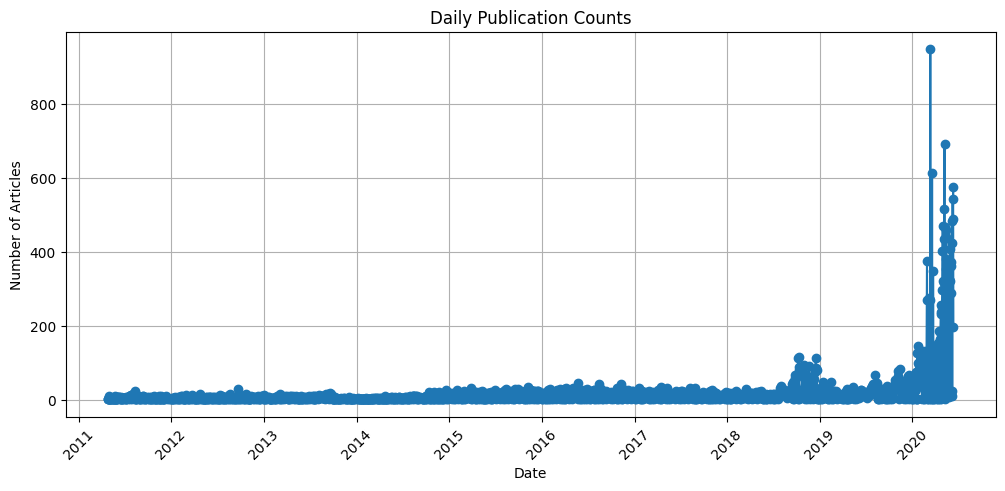

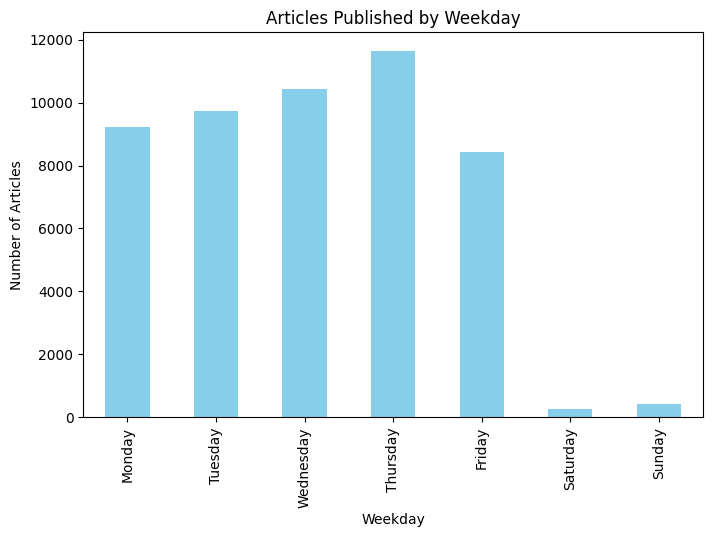

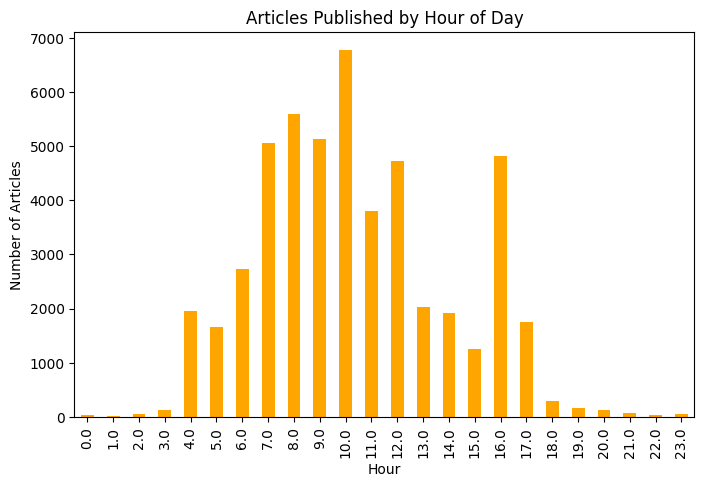

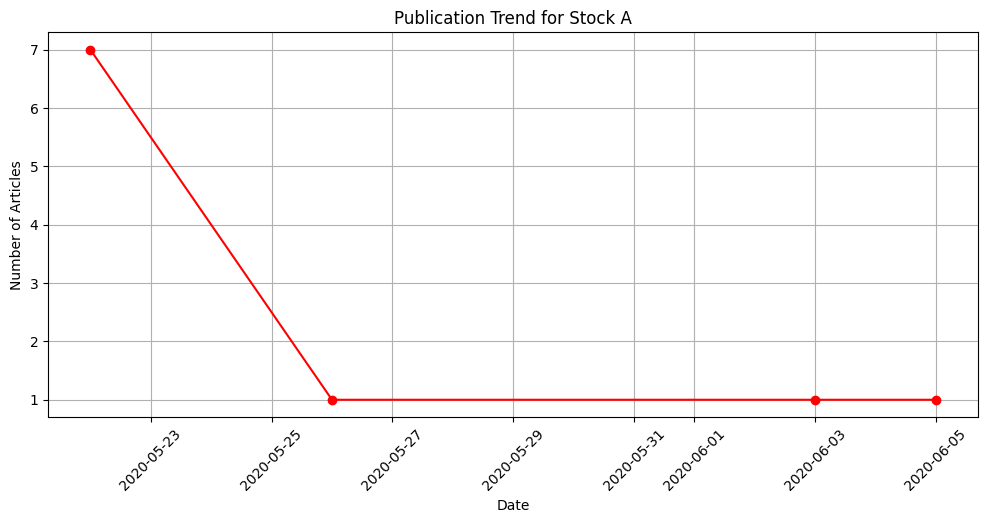

In [22]:
# 1️⃣ Daily publication counts
daily_counts = df_clean.groupby(df_clean['date'].dt.date)['headline'].count()
plt.figure(figsize=(12,5))
daily_counts.plot(kind='line', marker='o')
plt.title("Daily Publication Counts")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 2️⃣ Weekday trends
weekday_counts = df_clean.groupby(df_clean['date'].dt.day_name())['headline'].count()
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_counts = weekday_counts.reindex(weekday_order)
plt.figure(figsize=(8,5))
weekday_counts.plot(kind='bar', color='skyblue')
plt.title("Articles Published by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Articles")
plt.show()

# 3️⃣ Hour-of-day trends
hour_counts = df_clean.groupby(df_clean['date'].dt.hour)['headline'].count()
plt.figure(figsize=(8,5))
hour_counts.plot(kind='bar', color='orange')
plt.title("Articles Published by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Articles")
plt.show()


# 5️⃣ Optional: Stock-specific publication trends
# Example: for stock 'A'
stock_A_counts = df_clean[df_clean['stock'] == 'A'].groupby(df_clean['date'].dt.date)['headline'].count()
plt.figure(figsize=(12,5))
stock_A_counts.plot(kind='line', marker='o', color='red')
plt.title("Publication Trend for Stock A")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Checking for the stock and publisher dataset

In [23]:
df_clean['stock'].unique()

array(['A', 'AA', 'AAC', ..., 'ZU', 'ZUMZ', 'ZX'],
      shape=(6196,), dtype=object)

In [24]:
df_clean['stock'].nunique()

6196

The 10 Most Frequently Mentioned Stocks in the Dataset

In [25]:
print(df_clean['stock'].value_counts().head(10))

stock
MRK     3086
MS      3060
EBAY    2888
M       2869
NVDA    2845
MU      2841
VZ      2800
JNJ     2728
NFLX    2727
DAL     2706
Name: count, dtype: int64


In [26]:
df_clean['publisher'].unique()

array(['Benzinga Insights', 'Lisa Levin', 'Vick Meyer', ...,
       'Robert Morris', 'LeftCoastHedgie', 'Jeremie Capron'],
      shape=(1034,), dtype=object)

In [27]:
df_clean['publisher'].nunique()

1034

Text Analysis(Topic Modeling):

Preprocessing the headline column by removing stopwords and tokenizing the text for subsequent analysis.

In [28]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text):
        return []
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return words

# Apply preprocessing to the headline column
df_clean['processed_headline'] = df_clean['headline'].apply(preprocess_text)

Displaying the top keywords: 'stocks', 'reports', 'update', and 'market' are among the most frequent terms in the headline column.

In [29]:
# Flatten all words
all_words = [word for tokens in df_clean['processed_headline'] for word in tokens]
word_freq = Counter(all_words)

# Top 20 keywords
common_keywords = word_freq.most_common(20)
print("Top keywords:")
print(common_keywords)

Top keywords:
[('stocks', 155285), ('vs', 151264), ('est', 130749), ('eps', 122281), ('reports', 103896), ('update', 85189), ('market', 83501), ('earnings', 80918), ('top', 77358), ('shares', 76579), ('pt', 72820), ('sales', 72368), ('announces', 64606), ('downgrades', 61509), ('buy', 61011), ('upgrades', 56442), ('raises', 56301), ('benzingas', 54828), ('price', 52288), ('maintains', 52014)]


Displaying the top phrases

In [30]:
# Combine processed headlines back into strings
df_clean['processed_headline_str'] = df_clean['processed_headline'].apply(lambda x: ' '.join(x))

# Extract bigrams and trigrams
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X = vectorizer.fit_transform(df_clean['processed_headline_str'])

# Sum frequency of each n-gram
sum_words = X.sum(axis=0)
ngrams_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)

# Top 20 phrases
print("Top phrases:")
print(ngrams_freq[:20])


Top phrases:
[('price target', np.int64(45715)), ('stocks moving', np.int64(39963)), ('market update', np.int64(33079)), ('earnings scheduled', np.int64(31843)), ('initiates coverage', np.int64(28919)), ('raises pt', np.int64(27175)), ('premarket session', np.int64(21657)), ('benzingas upgrades', np.int64(20502)), ('vs est', np.int64(20387)), ('adj eps', np.int64(20047)), ('stocks hit', np.int64(20030)), ('q1 eps', np.int64(20015)), ('hit 52week', np.int64(19964)), ('stocks hit 52week', np.int64(19903)), ('q2 eps', np.int64(19492)), ('q3 eps', np.int64(19426)), ('q4 eps', np.int64(19153)), ('new 52week', np.int64(18251)), ('biggest movers', np.int64(17795)), ('reports q4', np.int64(17113))]


Publisher Analysis:

In [34]:
# Example: top 5 publishers and the stocks they report on
top5_publishers = publisher_counts.head(5).index
for pub in top5_publishers:
    print(f"\nPublisher: {pub}")
    print(df_clean[df_clean['publisher'] == pub]['stock'].value_counts().head(10))


Publisher: Paul Quintaro
stock
XRT     522
AGN     506
JCP     504
EBAY    498
BBRY    487
JNJ     460
P       449
VZ      445
QCOM    441
MRK     440
Name: count, dtype: int64

Publisher: Lisa Levin
stock
GPRO    523
MU      421
NVDA    357
PCG     336
CHK     311
BBBY    272
NVAX    271
ADBE    267
RH      265
BBW     265
Name: count, dtype: int64

Publisher: Benzinga Newsdesk
stock
EWU      671
TSLA     503
FXI      456
EWW      449
RSX      431
GOOGL    379
NFLX     329
PCG      326
GOOG     312
EWC      279
Name: count, dtype: int64

Publisher: Charles Gross
stock
GREK    622
NBG     565
BBRY    480
AZN     473
NVS     423
QCOM    414
EWU     406
EWI     400
MU      397
BABA    397
Name: count, dtype: int64

Publisher: Monica Gerson
stock
AA      216
MS      199
GPS     198
SNDK    198
M       196
MU      195
NTAP    188
ADBE    179
DAL     176
URBN    176
Name: count, dtype: int64


The dataset contains around 6,425 entries with publisher names in email format, representing 8 unique publishers.

publisher_domain
benzinga.com              6274
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


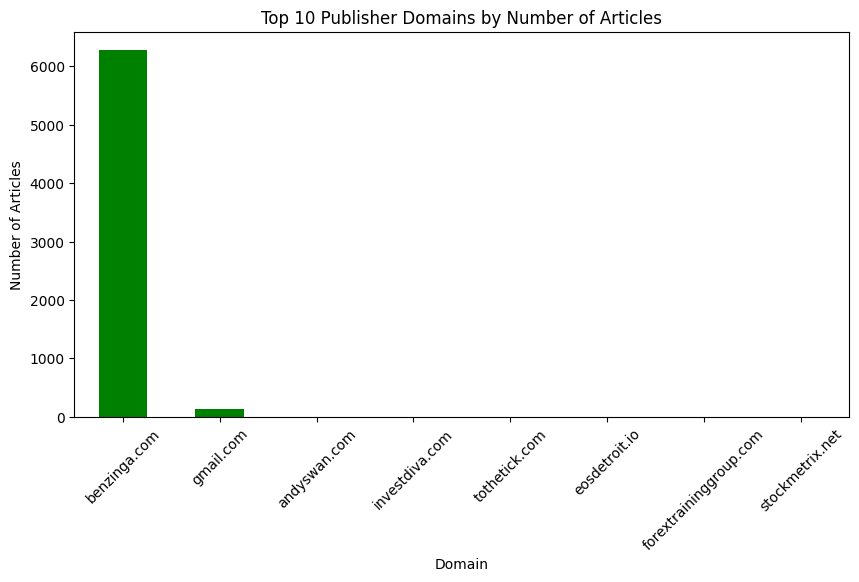

In [35]:
# Extract domain from email-like publisher names
df_clean['publisher_domain'] = df_clean['publisher'].str.extract(r'@([\w\.-]+)$')

# Count articles per domain
domain_counts = df_clean['publisher_domain'].value_counts().head(10)
print(domain_counts)

# Optional bar chart
plt.figure(figsize=(10,5))
domain_counts.plot(kind='bar', color='green')
plt.title("Top 10 Publisher Domains by Number of Articles")
plt.xlabel("Domain")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.show()
